In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.linear_model import Ridge,Lasso,ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import seaborn as sns
import statistics
import random
import warnings

pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)

pd.options.display.float_format = '{:.3f}'.format

warnings.filterwarnings("ignore")

In [58]:
train_df2 = pd.read_csv('./datasets/train_df_part2.csv')
test_df2 = pd.read_csv('./datasets/test_df_part2.csv')
corr_features_df = pd.read_csv('./datasets/corr_features_df_part2.csv')

In [3]:
#  Extracting ID as it will be used later for submission to kaggle
train_id = train_df2['id']
test_id = test_df2['id']

In [4]:
#Setting seed to ensure same results
np.random.seed(10)

## Baseline Model

In [5]:
# Displaying the RMSE of the baseline model, which is the prediction of mean against the y values
# We will need to do better than 79,000 or we should just guess the mean price for each house

np.sqrt(mean_squared_error(train_df2['saleprice'], [train_df2['saleprice'].mean()]* len(train_df2)))

79019.7292438924

## Model Based on EDA and Research

Based on our exploratory data analysis of scatterplot, boxplot etc., we see that features depicting area, neighborhood, age and condition of house are important factors to consider when pricing houses. This is also highlighted when we did further research <sup> 5 6 7 </sup>. We will hence extract these features and build our model.

1. https://www.99.co/singapore/insider/factors-affecting-resale-value/ (Factors highlighted: Size, Age and house Condition)
    

2. https://www.thebalance.com/pricing-houses-to-sell-1798968 (Factors highlighted: Size, Age and neighborhood)
    

3. https://www.compmort.com/home-location-and-property-value/ (Factors highlighted: Neighborhood)

In [6]:
# Filtering out neighborhood features

neigh_columns = train_df2.columns[train_df2.columns.str.contains('neighborhood')].to_list()

# Adding on features describing condition, age, location and size

research_features = neigh_columns + ['overall_cond', 'age_sold', 'age_since_remod', 'mas_vnr_area', 
'exter_cond', 'bsmt_cond', 'bsmtfin_sf_1', 'total_bsmt_sf', 'bsmt_unf_sf', 'heating_qc', '1st_flr_sf', 
'2nd_flr_sf', 'gr_liv_area', 'garage_yr_blt', 'garage_area', 'garage_cond']

In [7]:
# Identify our independent variable(x) and dependent variable(y)
x = train_df2[research_features]
y = train_df2['saleprice']

# Splitting dependent and independent variable
x_train, x_test, y_train, y_test = train_test_split(x,y)

# Scaling our variables
ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [8]:
#Linear Regression Model 1

lr = LinearRegression()

lr_scores = -cross_val_score(lr, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(lr_scores))}')

lr.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,lr.predict(x_test_sc)))}')

'CV RMSE: 3.194894426192015e+16'

'Test RMSE: 30404.56841376769'

In [9]:
#Lasso model 1
lasso = LassoCV(n_alphas= 200)

lasso_scores = -cross_val_score(lasso, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(lasso_scores))}')

lasso.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,lasso.predict(x_test_sc)))}')

display(f'Optimal Alpha :{lasso.alpha_}')

'CV RMSE: 29268.54449839148'

'Test RMSE: 30609.924986512022'

'Optimal Alpha :175.8869522183819'

In [10]:
#Ridge model 1
ridge = RidgeCV(alphas = np.logspace(0,5,200))

ridge_scores = -cross_val_score(ridge, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(ridge_scores))}')

ridge.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,ridge.predict(x_test_sc)))}')

display(f'Optimal Alpha :{ridge.alpha_}')

'CV RMSE: 29257.505189465734'

'Test RMSE: 30509.733017704297'

'Optimal Alpha :32.17641750250737'

In [11]:
#ElasticNet Model 1
enet = ElasticNetCV(l1_ratio=np.linspace(0.001, 1, 50), n_alphas=200)

enet_scores = -cross_val_score(enet, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(enet_scores))}')

enet.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,enet.predict(x_test_sc)))}')

display(f'Optimal Alpha :{enet.alpha_}')

'CV RMSE: 29268.54449839148'

'Test RMSE: 30609.924986512022'

'Optimal Alpha :175.8869522183819'

### Analysis

We noticed that there is an improvement from the baseline model, with RMSE of each model about 29,000. The lasso model is a penalized regression which pushes the coefficients of features that do not have a relationship with the dependent variable to zero. Hence, let us inspect the model to identify which features which we should take out. 

In [12]:
lasso_coeff = pd.DataFrame(lasso.coef_.T,index = x.columns,columns=['coeff']).sort_values(by='coeff',ascending=False)

lasso_coeff

,coeff
gr_liv_area,15086.942
total_bsmt_sf,14328.470
1st_flr_sf,13719.252
2nd_flr_sf,13055.329
garage_area,10410.233
neighborhood_NridgHt,10318.415
neighborhood_StoneBr,9337.485
overall_cond,7719.352
mas_vnr_area,6747.283
bsmtfin_sf_1,6669.919


### Analysis

We see that several neighborhoods College Creek and OLd Town have been reduced to 0. Garage condition has also been removed. Let us filter them out, as well as those that have small coefficients, indicating little relationship with sale price. As we will be communicating these features to house sellers, we want to streamline the features as much as possible rather than provide them with a long list. We will store them as a list for future use.

In [13]:
high_coeff = lasso_coeff[lasso_coeff['coeff']>5000].index.tolist()

low_coeff = lasso_coeff[lasso_coeff['coeff']<-5000].index.tolist()

### Analysis

Let us try a different approach by plotting out the highly correlated features as identified in part 2 EDA through our heatmap.

## Model Based On Heatmap High Correlatation

In [14]:
x = corr_features_df
y = train_df2['saleprice']

x_train, x_test, y_train, y_test = train_test_split(x,y)

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [15]:
#linear Regression Model 2

lr = LinearRegression()

lr_scores = -cross_val_score(lr, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')


display(f'CV RMSE: {np.sqrt(np.mean(lr_scores))}')

lr.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,lr.predict(x_test_sc)))}')

'CV RMSE: 28814.544532518572'

'Test RMSE: 32836.17209671192'

In [16]:
# Lasso Model 2

lasso = LassoCV(n_alphas= 200)

lasso_scores = -cross_val_score(lasso, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(lasso_scores))}')

lasso.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,lasso.predict(x_test_sc)))}')

display(f'Optimal Alpha :{lasso.alpha_}')

lasso.score(x_test_sc,y_test)

'CV RMSE: 28827.34317897209'

'Test RMSE: 32836.349702361535'

'Optimal Alpha :62.33987406642183'

0.8472406703438246

In [17]:
# Ridge Model 2

ridge = RidgeCV(alphas = np.logspace(0,5,200))

ridge_scores = -cross_val_score(ridge, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(ridge_scores))}')

ridge.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,ridge.predict(x_test_sc)))}')

display(f'Optimal Alpha :{ridge.alpha_}')

'CV RMSE: 28815.69616828828'

'Test RMSE: 32852.594869957655'

'Optimal Alpha :18.041864093920726'

In [18]:
# Enet Model 2

enet = ElasticNetCV(l1_ratio=np.linspace(0.001, 1, 50), n_alphas=200)

enet_scores = -cross_val_score(enet, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(enet_scores))}')

enet.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,enet.predict(x_test_sc)))}')

display(f'Optimal Alpha :{enet.alpha_}')

'CV RMSE: 28827.34317897209'

'Test RMSE: 32836.349702361535'

'Optimal Alpha :62.33987406642183'

### Analysis

We can see that our test RMSE has actually increased to about 30,000. Looks like this model is even worse than our previous one. However, I believe that we can improve our model further. Let us try joining features from both models together. We will also create interaction terms to see what affect the combination of features have on sale prices.

[Text(0.5, 1.0, 'Heatmap of features against saleprice')]

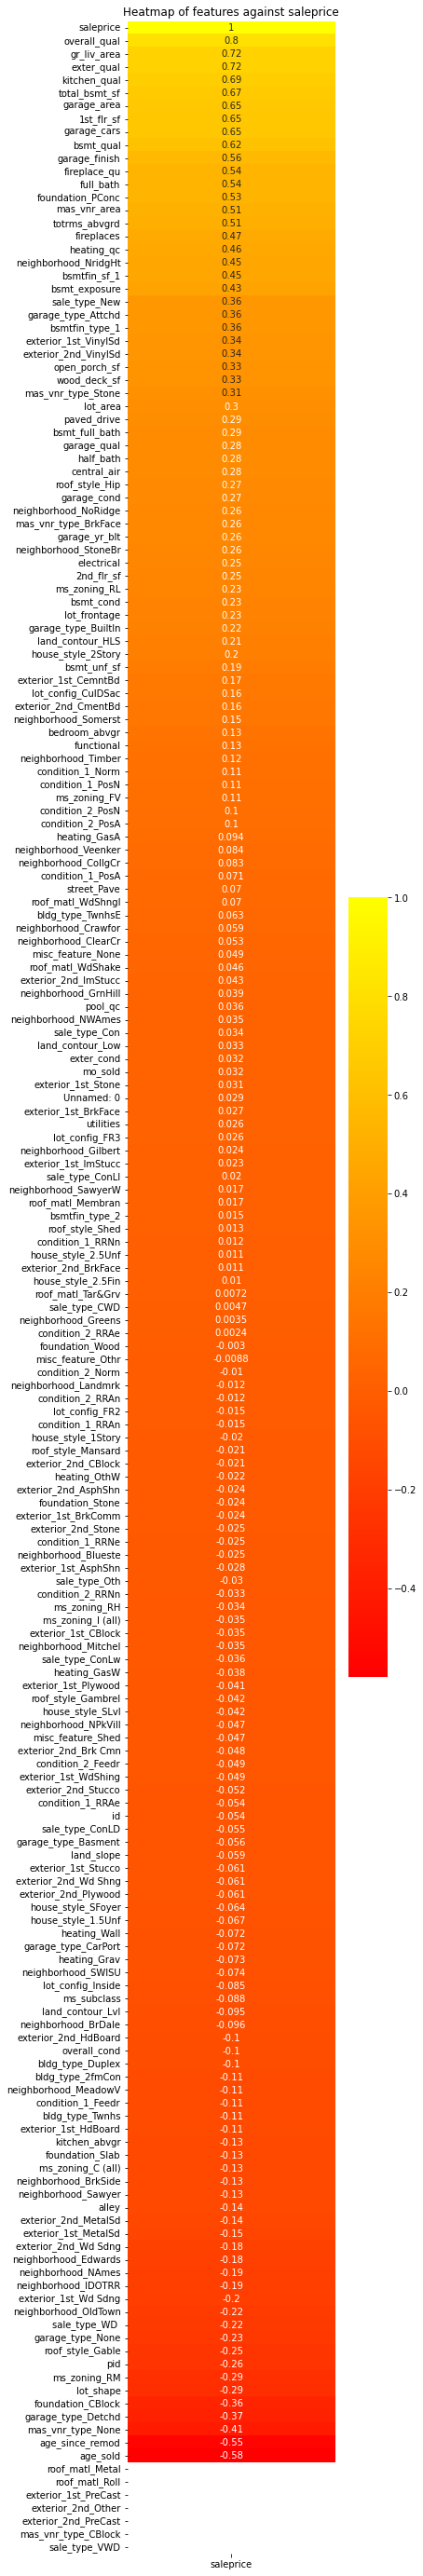

In [19]:
# Plotting heatmap from EDA part 2 to illustrate the highly features once again
plt.figure(figsize=(5,50))

sns.heatmap(train_df2.corr()[['saleprice']].sort_values('saleprice',ascending=False),
            annot=True,cmap = 'autumn').set(title = 'Heatmap of features against saleprice')


In [20]:
# Displaying the columns with high positive correlation

heat_df = train_df2.corr()[['saleprice']].sort_values('saleprice',ascending=False)

heat_df.loc[heat_df['saleprice']>0.5]

,saleprice
saleprice,1.000
overall_qual,0.803
gr_liv_area,0.719
exter_qual,0.717
kitchen_qual,0.693
total_bsmt_sf,0.670
garage_area,0.655
1st_flr_sf,0.652
garage_cars,0.648
bsmt_qual,0.622


In [21]:
# Displaying the columns with high negative correlation
heat_df.loc[heat_df['saleprice']<-0.5]

,saleprice
age_since_remod,-0.553
age_sold,-0.580


## Polynomial Model

In [22]:
# We store split the positive and negative terms. 
# Also remember that we had dropped garage cars previously due to multi collinearity

poly_pos_terms = ['overall_qual', 'gr_liv_area', 'exter_qual', 'kitchen_qual',
       'total_bsmt_sf', 'garage_area', '1st_flr_sf', 'bsmt_qual',
       'garage_finish', 'fireplace_qu', 'full_bath', 'mas_vnr_area',
       'totrms_abvgrd', 'foundation_CBlock', 'foundation_PConc',
       'foundation_Slab', 'foundation_Stone', 'foundation_Wood']

In [23]:
poly_neg_terms = ['age_since_remod', 'age_sold']

In [24]:
# Displaying the high and low coefficient terms that we have identified in model 1 through our lasso model
high_coeff

['gr_liv_area',
 'total_bsmt_sf',
 '1st_flr_sf',
 '2nd_flr_sf',
 'garage_area',
 'neighborhood_NridgHt',
 'neighborhood_StoneBr',
 'overall_cond',
 'mas_vnr_area',
 'bsmtfin_sf_1']

In [25]:
low_coeff

['age_sold']

In [26]:
# Creating our new polynomial lists
new_pos_list = poly_pos_terms + list(set(high_coeff) - set(poly_pos_terms))
new_neg_list = poly_neg_terms + list(set(low_coeff) - set(poly_neg_terms))

In [27]:
# Storing the positive and negative terms seperately as we want the positive terms to interact with the positive terms
# and vice versa
train_1 = train_df2[new_pos_list]
train_2 = train_df2[new_neg_list]
y = train_df2['saleprice']
test_1 = test_df2[new_pos_list]
test_2 = test_df2[new_neg_list]

In [28]:
# Creating interaction terms
poly1 = PolynomialFeatures(degree=2,include_bias=False)

poly_train_1 = poly1.fit_transform(train_1)

poly_test_1 = poly1.fit_transform(test_1)

In [29]:
poly2 = PolynomialFeatures(degree=2,include_bias=False)

poly_train_2 = poly2.fit_transform(train_2)

poly_test_2 = poly2.fit_transform(test_2)

In [30]:
# Storing them into dataframes
x_poly_train_1 = pd.DataFrame(poly_train_1, columns = poly1.get_feature_names(train_1.columns))
x_poly_train_2 = pd.DataFrame(poly_train_2, columns = poly2.get_feature_names(train_2.columns))

# tagging id onto them so that we can merge the negative and positive columns together 
# after creating the interaction terms
x_poly_train_1['id'] = train_id
x_poly_train_2['id'] = train_id

x_poly_test_1 = pd.DataFrame(poly_test_1, columns = poly1.get_feature_names(test_1.columns))
x_poly_test_2 = pd.DataFrame(poly_test_2, columns = poly2.get_feature_names(test_2.columns))
x_poly_test_1['id'] = test_id
x_poly_test_2['id'] = test_id

train_poly_df = pd.merge(x_poly_train_1,x_poly_train_2,how='outer')

test_poly_df = pd.merge(x_poly_test_1,x_poly_test_2,how='outer')

In [31]:
# creating dep and indep variables and scaling them
x = train_poly_df.drop(['id'],axis=1)
y = train_df2['saleprice']

x_train, x_test, y_train, y_test = train_test_split(x,y)

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [32]:
# Linear Regression Model 3
lr = LinearRegression()

lr_scores = -cross_val_score(lr, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(lr_scores))}')

lr.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,lr.predict(x_test_sc)))}')

'CV RMSE: 1.7071628646233438e+16'

'Test RMSE: 25795.70327269114'

In [33]:
# Lasso Model 3

lasso = LassoCV(n_alphas= 200)

lasso_scores = -cross_val_score(lasso, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(lasso_scores))}')

lasso.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,lasso.predict(x_test_sc)))}')

display(f'Optimal Alpha :{lasso.alpha_}')

'CV RMSE: 23361.448464469937'

'Test RMSE: 22763.007066638256'

'Optimal Alpha :129.09293958840576'

In [34]:
#Ridge Model 3

ridge = RidgeCV(alphas = np.logspace(0,5,200))

ridge_scores = -cross_val_score(ridge, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(ridge_scores))}')

ridge.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,ridge.predict(x_test_sc)))}')

display(f'Optimal Alpha :{ridge.alpha_}')

'CV RMSE: 23207.23098323424'

'Test RMSE: 22428.544494276593'

'Optimal Alpha :64.42363508721374'

In [35]:
#Enet Model 3

enet = ElasticNetCV(l1_ratio=np.linspace(0.001, 1, 50), n_alphas=200)

enet_scores = -cross_val_score(enet, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(enet_scores))}')

enet.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,enet.predict(x_test_sc)))}')

display(f'Optimal Alpha :{enet.alpha_}')

'CV RMSE: 23361.448464469937'

'Test RMSE: 22763.007066638256'

'Optimal Alpha :129.09293958840576'

## Analysis

We observe that our RMSE has significantly reduced to ~22k. It thus seems to be the case that when we introduction interaction between the terms, the combination of them has a greater relationship with sale price. Though we have attained quite a good model, we also have to ensure practicality. Looking back at our problem statement, we need to communicate to sellers the features that affect sale price. However, we notice there are features that may be too complicated for sellers to identify. One such feature is Masonry veneer area (outer layer of brick or stone on a building), where most people will not know the term or have difficulty measuring it. Another is Basement Square Feet Type 1 which is hard to explain what type 1 actually is. Moreover, we have also already included basement unfinished squarefeet, and there is hence no need for this term. We will hence drop these 2 terms for our final model.

## Final Model

In [36]:
# final features
final_pos_features = ['overall_qual', 'gr_liv_area', 'exter_qual', 'kitchen_qual','total_bsmt_sf',
                   'garage_area','1st_flr_sf','bsmt_qual','garage_finish', 'fireplace_qu', 'full_bath',
                   'totrms_abvgrd', 'foundation_CBlock', 'foundation_PConc', 'foundation_Slab', 'foundation_Stone',
                   'foundation_Wood', 'overall_cond', 'neighborhood_StoneBr', 'neighborhood_NridgHt','2nd_flr_sf']
final_neg_features = ['age_since_remod', 'age_sold', 'bsmt_unf_sf']

In [37]:
# Storing the positive and negative terms seperately
train_1 = train_df2[final_pos_features]
train_2 = train_df2[final_neg_features]
y = train_df2['saleprice']
test_1 = test_df2[final_pos_features]
test_2 = test_df2[final_neg_features]

In [38]:
# Creating interaction terms
poly1 = PolynomialFeatures(degree=2,include_bias=False)

poly_train_1 = poly1.fit_transform(train_1)

poly_test_1 = poly1.fit_transform(test_1)

In [39]:
poly2 = PolynomialFeatures(degree=2,include_bias=False)

poly_train_2 = poly2.fit_transform(train_2)

poly_test_2 = poly2.fit_transform(test_2)

In [40]:
# Storing them into dataframes
x_poly_train_1 = pd.DataFrame(poly_train_1, columns = poly1.get_feature_names(train_1.columns))
x_poly_train_2 = pd.DataFrame(poly_train_2, columns = poly2.get_feature_names(train_2.columns))

# tagging id onto them so that we can merge the negative and positive columns together 
x_poly_train_1['id'] = train_id
x_poly_train_2['id'] = train_id

x_poly_test_1 = pd.DataFrame(poly_test_1, columns = poly1.get_feature_names(test_1.columns))
x_poly_test_2 = pd.DataFrame(poly_test_2, columns = poly2.get_feature_names(test_2.columns))
x_poly_test_1['id'] = test_id
x_poly_test_2['id'] = test_id

train_poly_df = pd.merge(x_poly_train_1,x_poly_train_2,how='outer')

test_poly_df = pd.merge(x_poly_test_1,x_poly_test_2,how='outer')

In [41]:
# creating dep and indep variables and scaling them
x = train_poly_df.drop(['id'],axis=1)
y = train_df2['saleprice']

x_train, x_test, y_train, y_test = train_test_split(x,y)

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [42]:
# Final Linear Regression Model 
lr = LinearRegression()

lr_scores = -cross_val_score(lr, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(lr_scores))}')

lr.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,lr.predict(x_test_sc)))}')

'CV RMSE: 6119185385387249.0'

'Test RMSE: 25206.341267177086'

In [43]:
# Final Lasso Model

lasso = LassoCV(n_alphas= 200)

lasso_scores = -cross_val_score(lasso, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(lasso_scores))}')

lasso.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,lasso.predict(x_test_sc)))}')

display(f'Optimal Alpha :{lasso.alpha_}')

'CV RMSE: 22694.38297136305'

'Test RMSE: 23909.156307996178'

'Optimal Alpha :100.43277867998046'

In [44]:
# Final Ridge Model

ridge = RidgeCV(alphas = np.logspace(0,5,200))

ridge_scores = -cross_val_score(ridge, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(ridge_scores))}')

ridge.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,ridge.predict(x_test_sc)))}')

display(f'Optimal Alpha :{ridge.alpha_}')

'CV RMSE: 22298.28099137652'

'Test RMSE: 23715.595787903985'

'Optimal Alpha :28.660676169482517'

In [45]:
# Final Enet Model

enet = ElasticNetCV(l1_ratio=np.linspace(0.001, 1, 50), n_alphas=200)

enet_scores = -cross_val_score(enet, x_train_sc , y_train, cv=5,scoring='neg_mean_squared_error')

display(f'CV RMSE: {np.sqrt(np.mean(enet_scores))}')

enet.fit(x_train_sc,y_train)

display(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,enet.predict(x_test_sc)))}')

display(f'Optimal Alpha :{enet.alpha_}')

'CV RMSE: 22694.38297136305'

'Test RMSE: 23909.156307996178'

'Optimal Alpha :100.43277867998046'

### Analysis

We see that our ridge model performed the best at 22.2k RMSE. This is a slight improvement from our previous RMSE score of 22.3k. Let us now study the coefficients and residuals of our model.

Text(0.5, 1.0, 'Predictions of Sale Price vs Actual Sale Price')

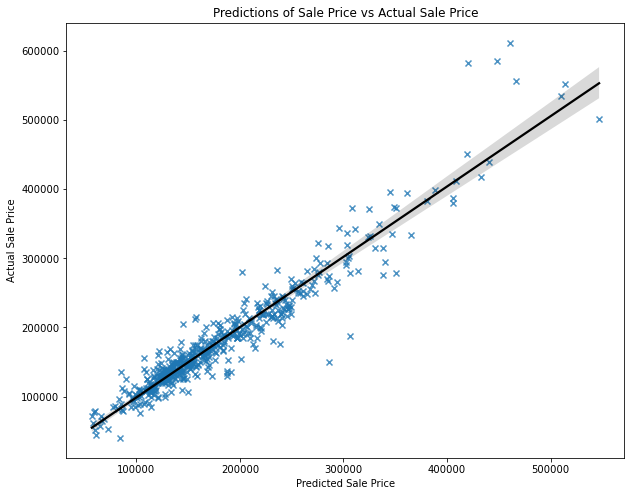

In [46]:
# Create scatterplot to show predicted values versus actual values
preds = ridge.predict(x_test_sc)

plt.figure(figsize=(10,8))
sns.regplot(x=preds, y=y_test, marker='x',line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.title('Predictions of Sale Price vs Actual Sale Price')

### Analysis

We see that most of our points are close to the diagonal line, which means that the predictions are quite accurate. However, we have to note that due to the lack of data for houses above sale price of $400k, our predictions for high value houses have higher residuals.

In [47]:
ridge_coeff = pd.DataFrame(ridge.coef_.T,index = x.columns,columns=['coeff']).sort_values(by='coeff',ascending=False)

ridge_coeff

,coeff
garage_area neighborhood_StoneBr,7192.607
total_bsmt_sf bsmt_qual,7169.366
fireplace_qu neighborhood_StoneBr,6587.881
exter_qual 1st_flr_sf,6497.566
overall_qual 1st_flr_sf,5826.512
kitchen_qual garage_area,5757.921
overall_qual garage_area,5643.356
totrms_abvgrd neighborhood_StoneBr,5604.489
1st_flr_sf fireplace_qu,5475.746
overall_cond,5467.816


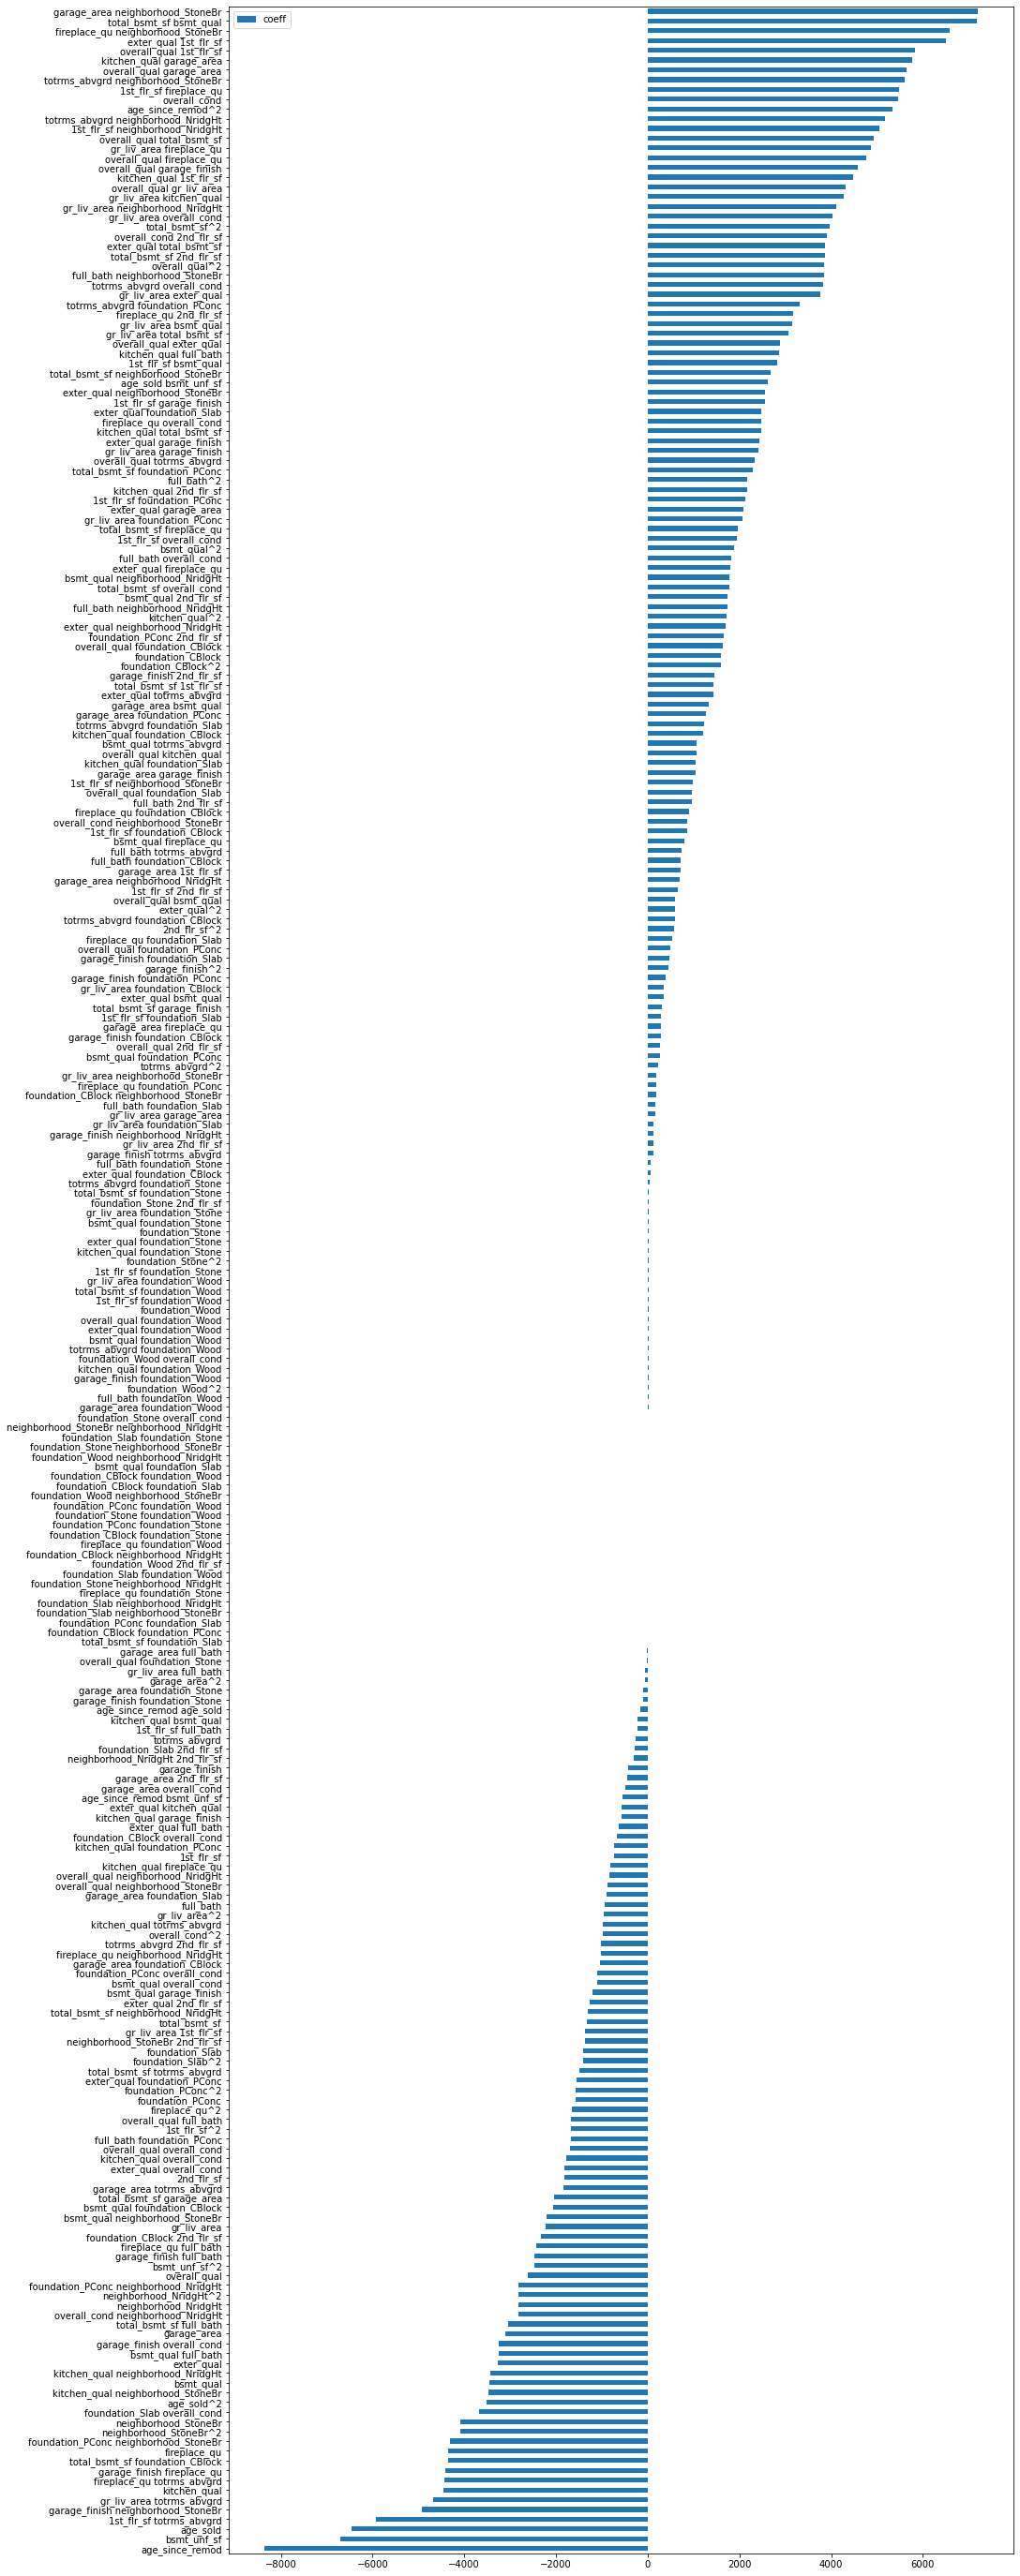

In [48]:
#Barchart illustrating coefficients
ridge_coeff.sort_values(by = 'coeff').plot.barh(figsize=(15,50))

### Analysis

We can see that the interaction of neighborhood terms for wealthy neighborhoods together with features such as number of rooms abive grade and garage area have the greatest positive relationship with sale price. The mixing of quality and area also produces features that have high positive relationship. On the other end, we observe that age since the last modification has the strongest negative relationship with sale price. Moreover, we note that the higher the area of unfinished basement square feet, the lesser the price, indicating a strong negative relationship.

In [49]:
# Training the on the whole train data before submission to kaggle

ss = StandardScaler()
x_final_sc = ss.fit_transform(x)

ridge = RidgeCV(alphas = np.logspace(0,5,200))

ridge.fit(x_final_sc,y)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]))

In [50]:
#Creating predictions file for kaggle

kaggle_test_df = test_poly_df.drop(['id'],axis=1)

#Transform kaggle test set

kaggle_test_df_sc = ss.transform(kaggle_test_df)

submit_df = pd.DataFrame({'Id': test_id,'SalePrice':ridge.predict(kaggle_test_df_sc)})
submit_df2 = submit_df.set_index('Id')

submit_df2.to_csv('submit_final')

## Conclusion and Recommendations

The model that have performed best with the most reasonable features to advise sellers is the Ridge Model, with a RMSE of 22.2k. Please see below for the list of features which sellers can refer to when trying to price their homes

In [51]:
final_features = final_pos_features + final_neg_features

final_coef_df = pd.DataFrame(final_features,columns = ['features'])

final_coef_df['relationship'] = '+'

final_coef_df.iloc[-3:,:]['relationship'] = '-'

final_coef_df

,features,relationship
0,overall_qual,+
1,gr_liv_area,+
2,exter_qual,+
3,kitchen_qual,+
4,total_bsmt_sf,+
5,garage_area,+
6,1st_flr_sf,+
7,bsmt_qual,+
8,garage_finish,+
9,fireplace_qu,+


**Recommendations**

From observing the features that have been identified as crucial in predicting house prices, we can see that area, quality, the type of neighborhood, condition and age all have a relationship with house prices. 


* Neighborhood: For neighborhoods, there is only a strong positive relationship when the house is in a wealthier neighborhood such as Stone Brook or Northridge Heights. This may be due to buyers being able to flaunt one's status <sup> 2 </sup>. Hence, sellers who have houses in these areas can expect to price their houses higher.


* Quality: We see that we have to care about many aspects of quality, such as exterior quality, kitchen quality and also basement quality. The materials used for foundation also plays an important role in fetching higher prices. Sellers should hence ensure that their exterior is refurbished with the best materials. Appliances and equipment in the kitchen should also be of high quality.


* Condition: We observe that houses with better condition do fetch higher prices. Hence, sellers should ensure that the house is undamaged and any damage is repaired immediately.


* Age: Out of all the features, age since last remodelling/addition has the highest negative relationship. We see a drop of -$7,813 with each unit increase of age since remodelled. Hence, sellers have to ensure that they modify or remodel whenever possible. Moreover, buyers hoping to resell houses should also not buy houses that are too old as old houses generally fetch lower prices.


* Size: As expected, the size of the house will affect the house price. Having more rooms above ground level dramatically increases the cost of the house, especially in combination with a wealthy neighborhood. As an unfinished basement has a high negative relationship with price, sellers should ensure that their basement is completed before selling.

**Further Research**

* If we want to generalize the model to Singapore's context, certain features such as fireplace quality will have to be removed. Most houses in Singapore also do not have garages.


* Moreover, goverment policies and economic factors such as inflation, supply and demand have great effect on housing prices <sup> 4 </sup>. Hence, our model can be expanded to include economic factors for a better prediction.


* The dataset includes distance from railroads, but does not include distance from schools, which may be an important factor in relation to house prices <sup> 3 </sup>. Moreover, we observe that the dataset does not have many houses with sale prices above $400,000. More prices of high value houses will result in a more comprehensive model.


* Logistic regression could also be applied to predict if the house has a high chance of being sold.


* Moreover, we should also note that as this data was from 2006-2010, housing prices will probably have risen since then. Sellers will hence have to obtain the latest data in order to price a house more accurately in current times.

## Outside Research

1. https://www.99.co/singapore/insider/factors-affecting-resale-value/

   Summary: We see that age, condition, size and location all play a part in housing valuation.


2. https://www.thebalance.com/pricing-houses-to-sell-1798968
   
   Summary: Perceptions of desirability causes neighborhoods to have a relationship with house prices. Wealthier neighborhoods allows for one to flaunt their status. Age of the house is also crucial


3. https://www.compmort.com/home-location-and-property-value/

   Summary: This article highlights the importance of neighborhoods and proximity to amenities like schools and hospitals.
   

4. https://www.investopedia.com/articles/mortages-real-estate/11/factors-affecting-real-estate-market.asp
   
   Summary: This article highlights how government policies/subsidies and economic factors like inflation and supply/demand have a relationship with house prices.